In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 655.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 2.8 MB/s eta 0:00:00


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load preprocessed datasets
with open('/content/drive/MyDrive/Colab Notebooks/object_detection_project/preprocessed/train_images.pkl', 'rb') as f:
    train_images = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/object_detection_project/preprocessed/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/object_detection_project/preprocessed/valid_images.pkl', 'rb') as f:
    valid_images = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/object_detection_project/preprocessed/valid_labels.pkl', 'rb') as f:
    valid_labels = pickle.load(f)

# Evaluate on test set
with open('/content/drive/MyDrive/Colab Notebooks/object_detection_project/preprocessed/test_images.pkl', 'rb') as f:
    test_images = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/object_detection_project/preprocessed/test_labels.pkl', 'rb') as f:
    test_labels = pickle.load(f)

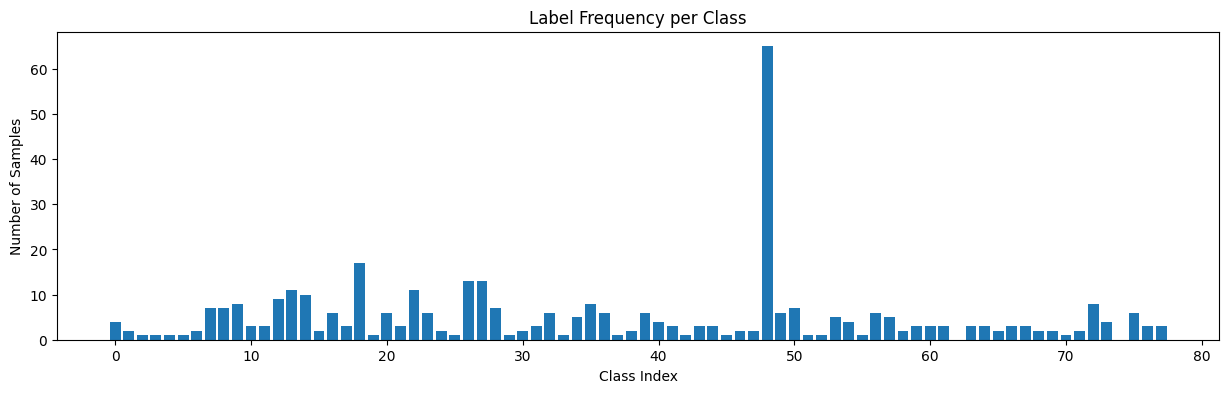

In [7]:
import matplotlib.pyplot as plt
import numpy as np

label_sums = np.sum(train_labels, axis=0)
plt.figure(figsize=(15, 4))
plt.bar(np.arange(len(label_sums)), label_sums)
plt.title("Label Frequency per Class")
plt.xlabel("Class Index")
plt.ylabel("Number of Samples")
plt.show()


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def build_custom_cnn(input_shape=(224, 224, 3), num_classes=78):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Classification head
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # prevent overfitting
    model.add(Dense(num_classes, activation='sigmoid'))  # sigmoid for multi-label

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model

model = build_custom_cnn()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 78)             │        20,046 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,803,662 (98.43 MB)

 Trainable params: 25,803,662 (98.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Build Model
# def build_model(input_shape=(224, 224, 3), num_classes=78):
#     base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
#     base_model.trainable = False  # You can set to True later for fine-tuning

#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(num_classes, activation='sigmoid')(x)

#     model = Model(inputs=base_model.input, outputs=outputs)
#     return model

# model = build_model()

In [9]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Train Model
history = model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=10,
    batch_size=16
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0417 - loss: 0.6311 - val_accuracy: 0.0000e+00 - val_loss: 0.3915
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.0112 - loss: 0.4478 - val_accuracy: 0.0000e+00 - val_loss: 0.2442
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.0192 - loss: 0.3990 - val_accuracy: 0.1455 - val_loss: 0.2318
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.0135 - loss: 0.3650 - val_accuracy: 0.1455 - val_loss: 0.2253
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.0636 - loss: 0.3372 - val_accuracy: 0.1455 - val_loss: 0.1995
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.0576 - loss: 0.3329 - val_accuracy: 0.1455 - val_loss: 0.1892
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.0646 - loss: 0.3047 - val_accuracy: 0.1455 - val_loss: 0.1781
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.0246 - loss: 0.2777 - val_accuracy: 0.1455 - val_loss: 0.1699


In [ ]:
# # Fine-tune full model
# model.trainable = True
# model.fit(train_images, train_labels,
#     validation_data=(valid_images, valid_labels),
#     epochs=50,
#     batch_size=16)  # retrain for a few more epochs


In [11]:
preds_0 = model.predict(train_images)
preds = (preds_0 > 0.1).astype(int)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step


In [12]:
preds_0[0]

array([2.10603997e-02, 6.26140926e-03, 1.43931219e-02, 2.57911757e-02,
       8.02207086e-03, 3.22698522e-03, 5.58224246e-02, 5.45276292e-02,
       2.41726153e-02, 1.03344545e-02, 2.09422922e-03, 3.96992154e-02,
       8.14168528e-03, 2.50546098e-01, 3.28601375e-02, 6.45444915e-02,
       1.39864394e-02, 2.22623367e-02, 6.69223294e-02, 3.60421389e-02,
       4.70224917e-02, 2.16007512e-02, 4.84649800e-02, 3.18015739e-02,
       8.59304518e-03, 3.13979499e-02, 3.39771360e-02, 5.75511716e-02,
       4.00591157e-02, 1.13838594e-02, 1.30083673e-02, 4.39951383e-02,
       3.85914445e-02, 1.36138285e-02, 2.15668697e-02, 1.39728680e-01,
       1.22267358e-01, 3.34996701e-04, 3.40755507e-02, 2.98960749e-02,
       1.02125462e-02, 2.65045874e-02, 4.30067442e-03, 7.85728171e-03,
       7.60218352e-02, 2.17491016e-02, 1.45142237e-02, 1.04285525e-02,
       4.97320056e-01, 5.40976599e-02, 1.15132574e-02, 1.82617903e-02,
       2.10216991e-03, 2.61123646e-02, 4.54739630e-02, 4.03900025e-03,
      

In [13]:
preds

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1]])

In [14]:
preds[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Plot Accuracy & Loss Curves

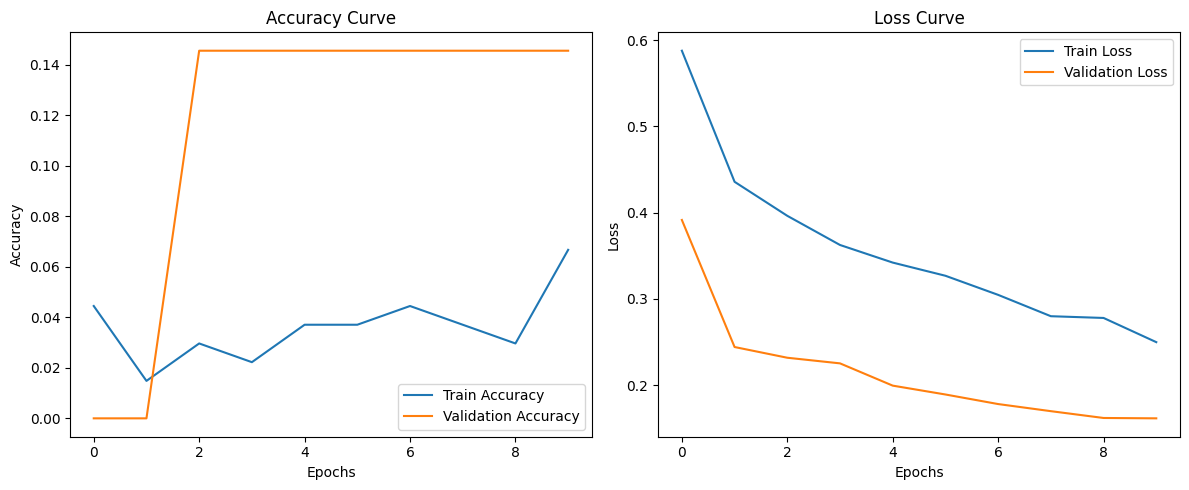

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Classification Report

In [16]:
from sklearn.metrics import classification_report
# Predict on test set
test_preds = model.predict(test_images)
test_preds = (test_preds > 0.1).astype(int)
print(classification_report(test_labels, test_preds, zero_division=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.06      1.00      0.11         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.17      0.50      0.25         2
          12       0.00      0.00      0.00         1
          13       0.12      1.00      0.21         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.0

# Plot Confusion Matrix

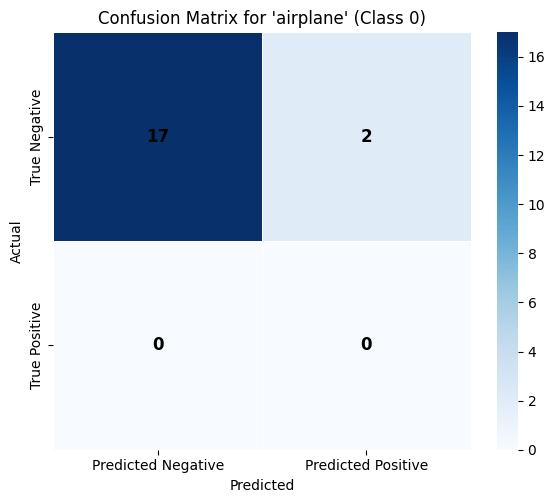

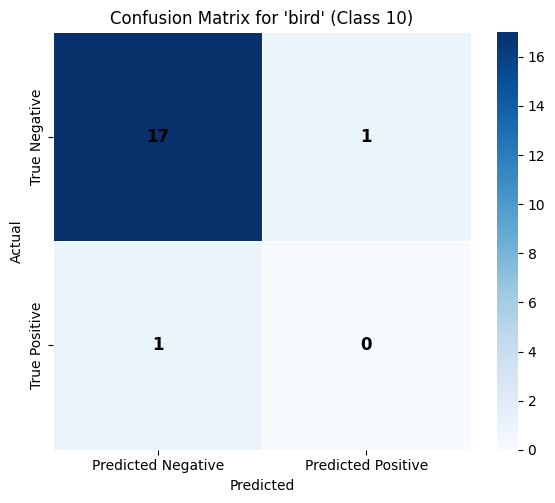

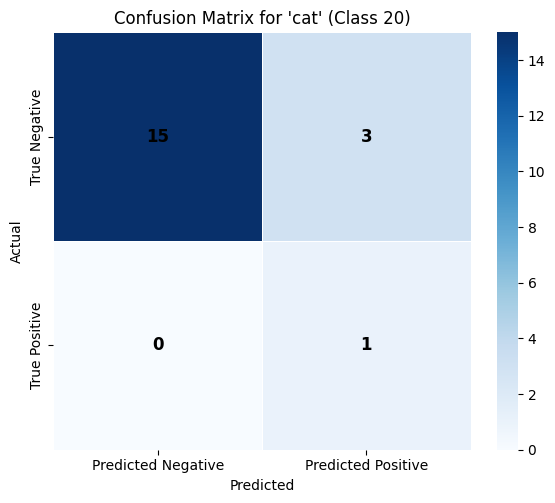

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = [
    "airplane", "apple", "backpack", "banana", "baseball bat", "baseball glove", "bear", "bed", "bench", "bicycle",
    "bird", "boat", "book", "bottle", "bowl", "broccoli", "bus", "cake", "car", "carrot", "cat", "cell phone", "chair",
    "clock", "couch", "cow", "cup", "dining table", "dog", "donut", "elephant", "fire hydrant", "fork", "frisbee",
    "giraffe", "handbag", "horse", "hot dog", "keyboard", "kite", "knife", "laptop", "microwave", "motorcycle",
    "mouse", "orange", "oven", "parking meter", "person", "pizza", "potted plant", "refrigerator", "remote",
    "sandwich", "scissors", "sheep", "sink", "skateboard", "skis", "snowboard", "spoon", "sports ball", "stop sign",
    "suitcase", "surfboard", "teddy bear", "tennis racket", "tie", "toilet", "toothbrush", "traffic light", "train",
    "truck", "tv", "umbrella", "vase", "wine glass", "zebra"
]

# Compute confusion matrices for all classes
mlcm = multilabel_confusion_matrix(test_labels, test_preds)

# Selected class indices to plot
selected_classes = [0, 10, 20]  # You can add more indices here

for cls_idx in selected_classes:
    cm = mlcm[cls_idx]
    class_name = CLASS_NAMES[cls_idx]

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm, annot=False, cmap="Blues", square=True,
                     xticklabels=["Predicted Negative", "Predicted Positive"],
                     yticklabels=["True Negative", "True Positive"],
                     cbar=True, linewidths=0.5, linecolor='white')

    # Manually add annotations (values inside the matrix)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = int(cm[i, j])
            ax.text(j + 0.5, i + 0.5, f"{value}", ha="center", va="center",
                    color="black", fontsize=12, fontweight='bold')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix for '{class_name}' (Class {cls_idx})")
    plt.tight_layout()
    plt.show()


In [18]:
import matplotlib.pyplot as plt

def display_prediction(image, prediction, threshold=0.3):
    """
    Shows image and prints predicted labels based on threshold.
    """
    predicted_classes = [CLASS_NAMES[i] for i, val in enumerate(prediction) if val > threshold]

    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted: " + ", ".join(predicted_classes) if predicted_classes else "No objects detected")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


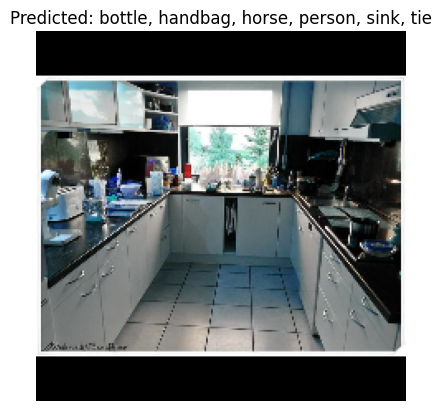

In [19]:
# Predict on a test image
index = 0  # change to see other images
test_img = train_images[index]
pred = model.predict(np.expand_dims(test_img, axis=0))[0]  # shape: (78,)
display_prediction(test_img, pred, threshold=0.1)


In [20]:
pred

array([2.1060262e-02, 6.2613999e-03, 1.4393147e-02, 2.5791125e-02,
       8.0221193e-03, 3.2269915e-03, 5.5822477e-02, 5.4527745e-02,
       2.4172563e-02, 1.0334481e-02, 2.0942395e-03, 3.9699268e-02,
       8.1416899e-03, 2.5054625e-01, 3.2860141e-02, 6.4544596e-02,
       1.3986355e-02, 2.2262387e-02, 6.6922247e-02, 3.6041979e-02,
       4.7022533e-02, 2.1600751e-02, 4.8465077e-02, 3.1801526e-02,
       8.5930768e-03, 3.1397924e-02, 3.3976998e-02, 5.7551172e-02,
       4.0059097e-02, 1.1383839e-02, 1.3008318e-02, 4.3995157e-02,
       3.8591467e-02, 1.3613879e-02, 2.1567006e-02, 1.3972941e-01,
       1.2226747e-01, 3.3499446e-04, 3.4075532e-02, 2.9895997e-02,
       1.0212542e-02, 2.6504636e-02, 4.3006800e-03, 7.8572659e-03,
       7.6021224e-02, 2.1749081e-02, 1.4514210e-02, 1.0428592e-02,
       4.9732059e-01, 5.4097686e-02, 1.1513219e-02, 1.8261783e-02,
       2.1021648e-03, 2.6112445e-02, 4.5473889e-02, 4.0390058e-03,
       1.5614125e-01, 2.1543363e-02, 2.3064492e-02, 1.4313747e

In [21]:
model.save('/content/drive/MyDrive/Colab Notebooks/object_detection_project/my_tuned_model_0.h5')
print("Best model saved to my_tuned_model.h5")

Best model saved to my_tuned_model.h5


In [ ]:
# Object detection is wrong and accuracy is low so let's do the hyperparameter tuning.

# Hyper parameter tuning

In [22]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [23]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def model_builder(hp):
    model = Sequential()

    # Conv Block 1
    hp_filters1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    model.add(Conv2D(filters=hp_filters1, kernel_size=3, activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=2))

    # Conv Block 2
    hp_filters2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    model.add(Conv2D(filters=hp_filters2, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))

    # Conv Block 3
    hp_filters3 = hp.Int('filters_3', min_value=128, max_value=256, step=64)
    model.add(Conv2D(filters=hp_filters3, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())

    # Dense Layer
    hp_units = hp.Int('dense_units', min_value=128, max_value=512, step=64)
    model.add(Dense(hp_units, activation='relu'))

    # Dropout
    hp_dropout = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(Dropout(hp_dropout))

    # Output Layer
    model.add(Dense(78, activation='sigmoid'))

    # Learning Rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model


In [ ]:
# import keras_tuner as kt
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# def model_builder(hp):
#     base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
#     base_model.trainable = True  # True for fine-tuning

#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)

#     # Tune the number of units in the dense layer
#     hp_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
#     x = Dense(units=hp_units, activation='relu')(x)

#     # Tune dropout rate
#     hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
#     x = Dropout(rate=hp_dropout)(x)

#     outputs = Dense(78, activation='sigmoid')(x)

#     model = Model(inputs=base_model.input, outputs=outputs)

#     # Tune learning rate
#     hp_lr = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

#     model.compile(
#         optimizer=Adam(learning_rate=hp_lr),
#         loss='binary_crossentropy',
#         metrics=['binary_accuracy']
#     )

#     return model


In [24]:
# Initialize the tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_binary_accuracy',
    max_epochs=10,
    factor=3,
    directory='cnn_tuner',
    project_name='multi_label_cnn'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# tuner = kt.Hyperband(
#     model_builder,
#     objective='val_binary_accuracy',
#     max_epochs=10,
#     factor=3,
#     directory='kt_dir',
#     project_name='multi_label_tuning'
# )

In [25]:
# Search for the best hyperparameters
# Use your own preprocessed train_images and train_labels here
tuner.search(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=10,
    batch_size=32
)


Trial 30 Complete [00h 06m 21s]
val_binary_accuracy: 0.965268075466156

Best val_binary_accuracy So Far: 0.9657343029975891
Total elapsed time: 01h 32m 29s


In [ ]:
# tuner.search(
#     train_images, train_labels,
#     epochs=10,
#     validation_data=(valid_images, valid_labels)
# )

In [27]:
# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Filters 1: {best_hps.get('filters_1')}")
print(f"Filters 2: {best_hps.get('filters_2')}")
print(f"Filters 3: {best_hps.get('filters_3')}")
print(f"Dense units: {best_hps.get('dense_units')}")
print(f"Dropout: {best_hps.get('dropout_rate')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

# Build and train the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=10)


Best Hyperparameters:
Filters 1: 96
Filters 2: 256
Filters 3: 256
Dense units: 448
Dropout: 0.4
Learning rate: 0.0001
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 96s 18s/step - binary_accuracy: 0.7046 - loss: 0.5754 - val_binary_accuracy: 0.9618 - val_loss: 0.1833
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step - binary_accuracy: 0.9177 - loss: 0.2704 - val_binary_accuracy: 0.9618 - val_loss: 0.1838
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step - binary_accuracy: 0.9333 - loss: 0.2714 - val_binary_accuracy: 0.9648 - val_loss: 0.1586
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step - binary_accuracy: 0.9352 - loss: 0.2282 - val_binary_accuracy: 0.9653 - val_loss: 0.1556
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step - binary_accuracy: 0.9368 - loss: 0.2222 - val_binary_accuracy: 0.9625 - val_loss: 0.1549
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step - binary_accuracy: 0.9464 - loss: 0.2020 - val_binary_accuracy: 0.9618 - val_loss: 0.1551
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step

In [ ]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"Best units: {best_hps.get('dense_units')}")
# print(f"Best dropout: {best_hps.get('dropout_rate')}")
# print(f"Best learning rate: {best_hps.get('learning_rate')}")

# # Build and train the best model
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(
#     train_images, train_labels,
#     validation_data=(valid_images, valid_labels),
#     epochs=20
# )

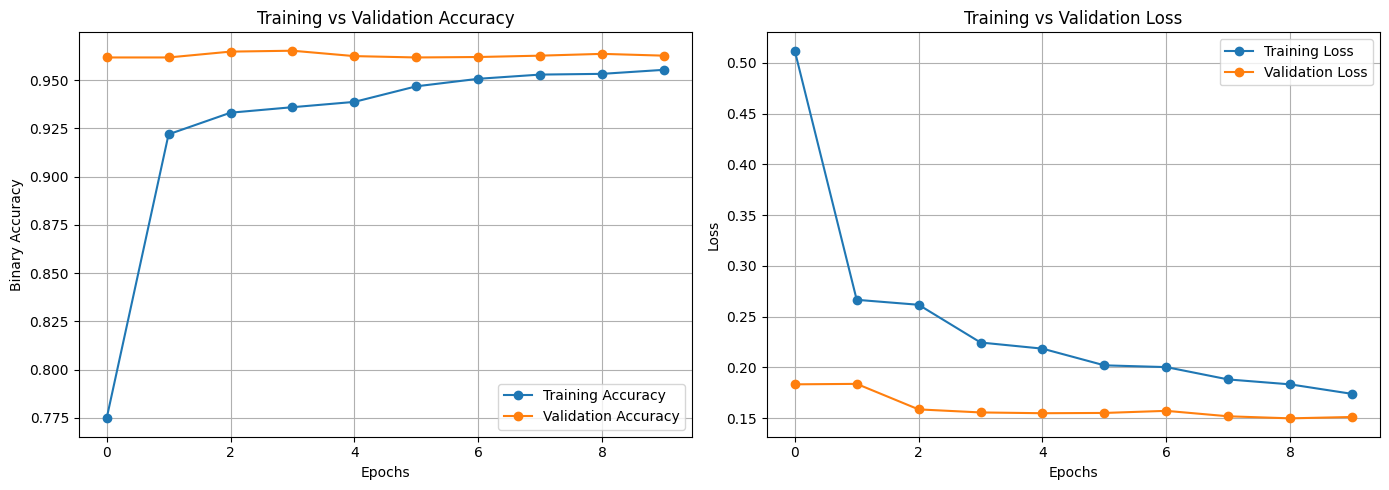

In [29]:
# Extract metrics from the history object
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plotting training vs validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.grid(True)

# Plotting training vs validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


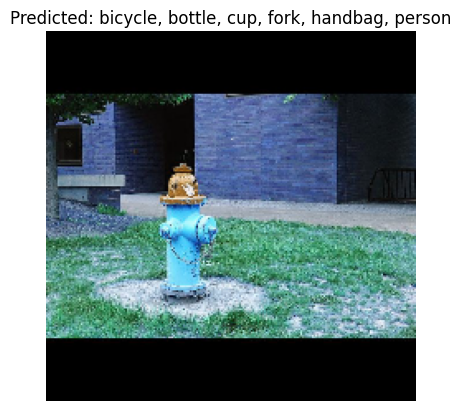

In [41]:
# Predict on a test image
index = 5  # change to see other images
test_img = train_images[index]
pred_best_model = model.predict(np.expand_dims(test_img, axis=0))[0]  # shape: (78,)
display_prediction(test_img, pred_best_model, threshold= 0.06)


In [32]:
pred_best_model

array([0.00348993, 0.00267901, 0.00524003, 0.00515941, 0.00053092,
       0.00504486, 0.02135678, 0.00541861, 0.01278941, 0.04616202,
       0.00558541, 0.00402172, 0.01197631, 0.08403477, 0.03230784,
       0.00172345, 0.0237121 , 0.00380531, 0.02485636, 0.00224072,
       0.00738849, 0.00870917, 0.02295585, 0.02673422, 0.00222235,
       0.00603626, 0.04593561, 0.01572894, 0.02467883, 0.00300371,
       0.00660792, 0.00761827, 0.02570863, 0.00677835, 0.00641116,
       0.01223808, 0.01202059, 0.00181013, 0.00911886, 0.00850381,
       0.01827311, 0.01115251, 0.00293787, 0.00396706, 0.01050657,
       0.00228131, 0.00425004, 0.00781666, 0.18894579, 0.04652082,
       0.02935206, 0.0007296 , 0.00372783, 0.00805939, 0.00607717,
       0.00072379, 0.03923398, 0.01034375, 0.00252523, 0.00253265,
       0.00338902, 0.00398105, 0.00540066, 0.00697237, 0.00564365,
       0.00182911, 0.01080134, 0.00585718, 0.00138659, 0.00111401,
       0.00106626, 0.00520961, 0.02125393, 0.01001788, 0.00324

In [28]:
model.save('/content/drive/MyDrive/Colab Notebooks/object_detection_project/my_tuned_model_1.h5')
print("Best model saved to my_tuned_model.h5")

Best model saved to my_tuned_model.h5


In [ ]:
# model look like overfitted 